In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from keras.applications import vgg16
import matplotlib.pyplot as plt
import time
from PIL import Image
import pandas as pd
import model_evaluation_utils as meu


In [15]:
def showNumpyImage(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()

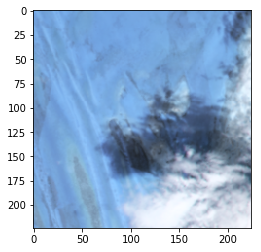

In [16]:
# Load Data
data = np.load("training_data.npy", allow_pickle = True)

# Split into labels and images then test and train
x = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Scale images
train_x_scaled = train_x.astype('float32')
test_x_scaled = test_x.astype('float32')
train_x_scaled /= 255
test_x_scaled /= 255

showNumpyImage(train_x_scaled[2645])

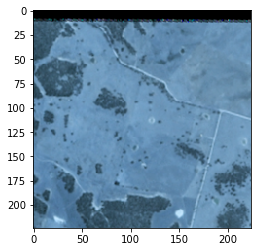

In [31]:
showNumpyImage(train_x[2645])

In [17]:
# Configure base model
input_shape = (224, 224, 3)
model_vgg16 = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
output = model_vgg16.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(model_vgg16.input, output)

# Set blocks 4 and 5 to be fine tuneable
vgg_model.trainable = True
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.topology.InputLayer object at 0x...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [19]:
# Run model for unaugmented data
from keras import optimizers
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history = model.fit(train_x_scaled, train_y, batch_size=32, epochs=10, 
                              verbose=1)       

Epoch 1/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0996 - acc: 0.9626
Epoch 2/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0562 - acc: 0.9805
Epoch 3/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0382 - acc: 0.9859
Epoch 4/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0340 - acc: 0.9899
Epoch 5/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0246 - acc: 0.9908
Epoch 6/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0237 - acc: 0.9917
Epoch 7/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0134 - acc: 0.9954
Epoch 8/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0251 - acc: 0.9954
Epoch 9/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0161 - acc: 0.9966
Epoch 10/10
3480/3480 [==============================] - 54s 15ms/step - loss: 0.0137 - acc: 0.9966


In [29]:
# Make predictions with model and convert predictions into binary
test_predictions = model.predict(test_x_scaled)
test_predictions_labelled = [0 if x<0.1 else 1 for x in test_predictions]

In [31]:
# Display performance metrics
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9494
Precision: 0.952
Recall: 0.9494
F1 Score: 0.9295

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       821
          1       1.00      0.10      0.19        49

avg / total       0.95      0.95      0.93       870


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0        821  0
        1         44  5


In [44]:
# Extract just fire images for augmentation
# TODO: this is not very efficient
data_df = pd.DataFrame(data)
just_fire = data_df[data_df[1] ==1]
just_fire_images = just_fire[0].tolist()
just_fire_labels = just_fire[1].tolist()

In [152]:
fire_data_aug = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [163]:
# Produce 12 random augmented image per fire image
from numpy import expand_dims
aug_images = []
aug_image_lables = []
for image in just_fire_images[0]:
    image = expand_dims(image,0)
    it = fire_data_aug.flow(image, batch_size=1)
    for i in range(12):
        batch = it.next()
        aug_images.append(batch[0])
        aug_image_lables.append(1)
    

In [164]:
# Create new augmented training and label set by combining original training and augmented training sets
train_x_aug = np.concatenate((train_x_scaled,np.array(aug_images)))
train_y_aug = np.concatenate((train_y,np.array(aug_image_lables)))

In [ ]:
# Run model with augmented data 
model_aug = Sequential()
model_aug.add(vgg_model)
model_aug.add(Dense(512, activation='relu', input_dim=input_shape))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
              
history_aug = model_aug.fit(train_x_aug, train_y_aug, batch_size=32, epochs=10, 
                              verbose=1)  

Epoch 1/10
5820/5820 [==============================] - 93s 16ms/step - loss: 0.0750 - acc: 0.9715
Epoch 2/10
5820/5820 [==============================] - 89s 15ms/step - loss: 0.0278 - acc: 0.9912
Epoch 3/10
1408/5820 [======>.......................] - ETA: 1:07 - loss: 0.0146 - acc: 0.9950

In [ ]:
# Make preditions with augmented data model & convert to binary
test_predictions_aug = model_aug.predict(test_x_scaled)
test_predictions_aug_labelled = [0 if x<0.1 else 1 for x in test_predictions_aug]

In [139]:
# Display performance metrics (9X augmentation, 3 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9678
Precision: 0.9722
Recall: 0.9678
F1 Score: 0.9695

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.99      0.98      0.98       821
          1       0.67      0.84      0.75        49

avg / total       0.97      0.97      0.97       870


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0        801  20
        1          8  41


In [142]:
# Display performance metrics (9X augmentation, 10 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9839
Precision: 0.9839
Recall: 0.9839
F1 Score: 0.9839

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       821
          1       0.86      0.86      0.86        49

avg / total       0.98      0.98      0.98       870


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0        814   7
        1          7  42


In [ ]:
# Display performance metrics (12X augmentation, incl. vertical_flip, 10 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))